In [27]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from GWB_Jax import OmegaGWjax
from interpax import CubicSpline
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import natpy as nat
import warnings
from getdist import plots,MCSamples,loadMCSamples
%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True) # if using latex in plots
matplotlib.rc('legend', fontsize=16)


(30, 25000)
2.177803682506613e-18
[-8.78139003 -8.80979287 -9.34944684 ... -8.86091798 -8.96600849
 -8.76718861]


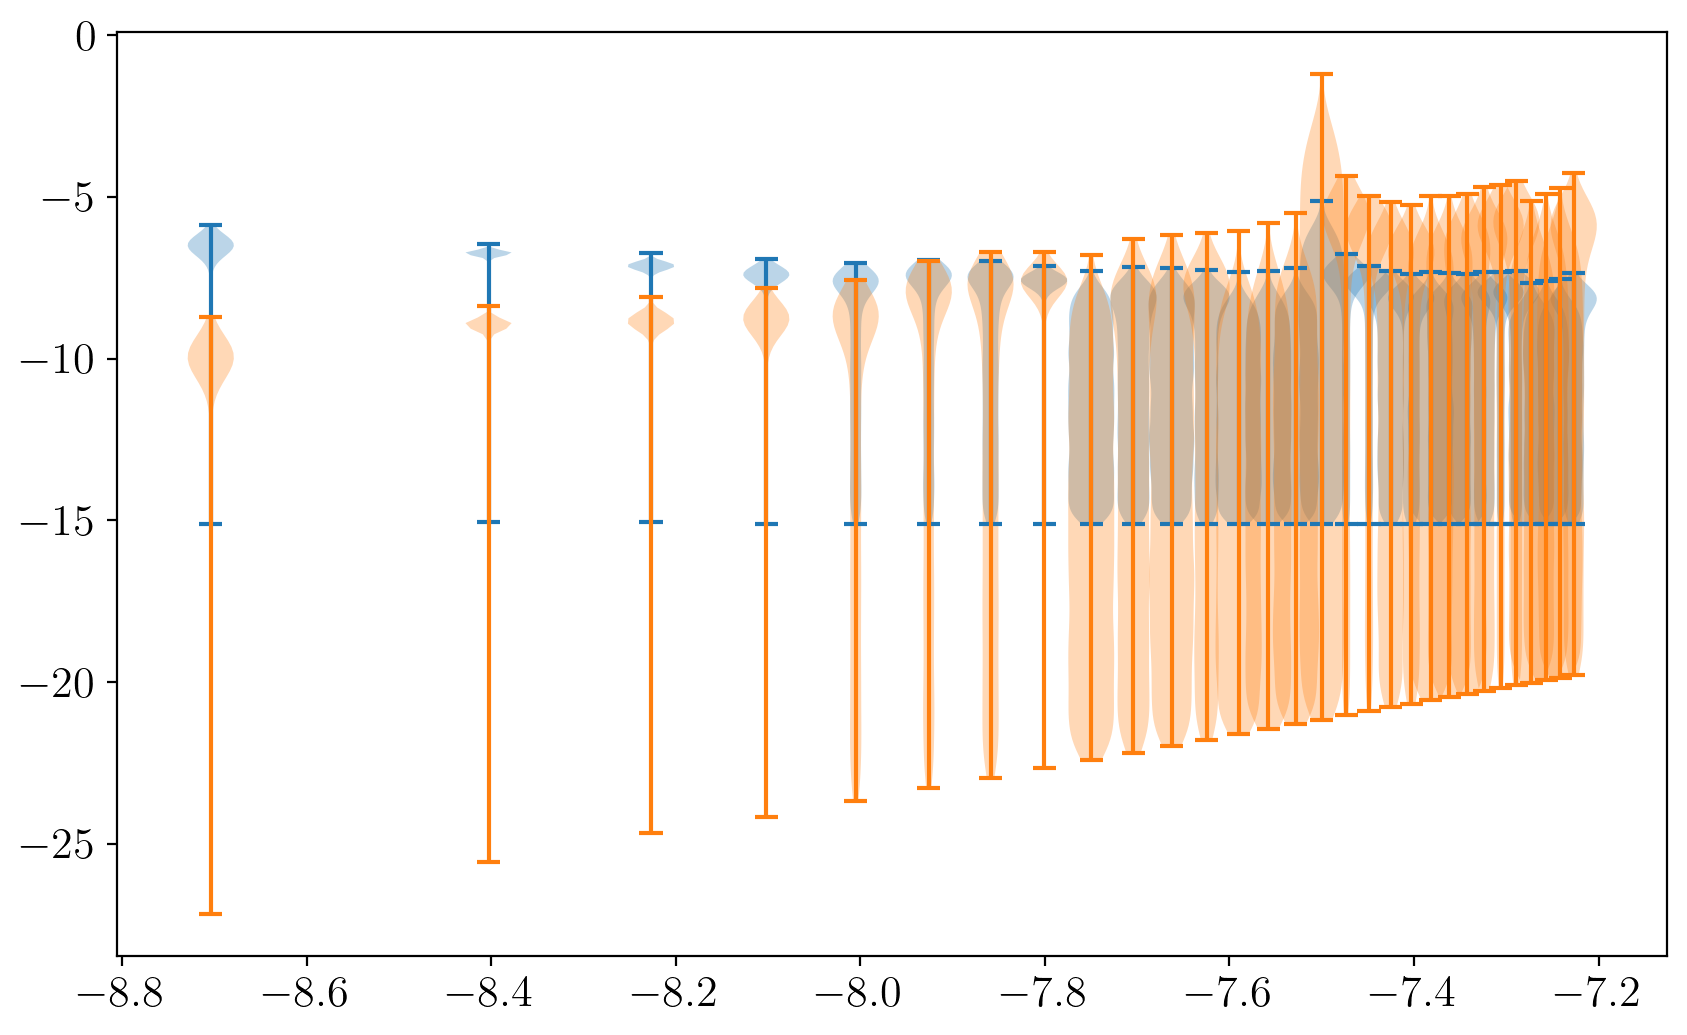

In [28]:
# Load data files
datadir = 'NANOGrav15yr_KDE-FreeSpectra_v1.0.0/30f_fs{cp}_ceffyl/'
density = np.load(datadir+"density.npy").squeeze(axis=0)          # shape: (n_frequencies, n_grid_points)
log10rhogrid = np.load(datadir+"log10rhogrid.npy")  # grid for log10rho values
freqs = np.load(datadir+"freqs.npy")                # GW frequencies
# Number of samples to draw from each KDE distribution
n_samples = 25000

# Prepare a list to store sampled data for each frequency
data_list = []

# Assuming density has shape (n_frequencies, n_grid_points)
for i in range(density.shape[0]):
    log_pdf = density[i]
    # Exponentiate the log PDF (subtract max for numerical stability)
    pdf = np.exp(log_pdf - np.max(log_pdf))
    # Normalize the PDF so that its sum equals 1
    pdf /= np.sum(pdf)
    
    # Draw samples from the log10rho grid weighted by the PDF
    samples = np.random.choice(log10rhogrid, size=n_samples, p=pdf)
    data_list.append(samples)

data_list = np.array(data_list)
# Create the violin plot using matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
# positions are set to the frequencies so that each violin appears at its GW frequency
v1 = ax.violinplot(list(data_list), np.log10(freqs), widths=0.05)


# convert to OmegaGW
Tspan = 15 * 365 * 24 * 3600
h = 0.672
print(data_list.shape)
H_0  = h * 100 * nat.convert(nat.km * nat.s**-1 * nat.Mpc**-1, nat.GeV) # Hubble constant (GeV)
H_0_Hz  = H_0 * nat.convert(nat.GeV, nat.Hz)
print(H_0_Hz)
OmegaGW_data = (8*np.pi**4 * freqs[:,None]**5 * h**2 * 10**(2 * data_list + np.log10(Tspan)) ) / (H_0_Hz**2)
OmegaGW_data  = np.log10(OmegaGW_data)
# print(OmegaGW_data.shape)
# print(data_list.shape)
v1 = ax.violinplot(list(OmegaGW_data), np.log10(freqs), widths=0.05)
# print(freqs)
# print(data)
print(OmegaGW_data[1])

In [31]:
chain_data = np.loadtxt("./chains/sigw_3_nodes/chain_0/chain_1.0.txt")

h = 0.67
num_nodes = 3
nodes = jnp.linspace(-9,-7,num_nodes)

# @jit
def spline(nodes, values, x):
    """
    Spline for frequency spectrum of Pz
    """
    spl = CubicSpline(nodes, values, check=False)
    res = 10**(spl(jnp.log10(x)))
    res = jnp.where(x < 10**nodes[0], 0.0, res)
    res = jnp.where(x > 10**nodes[-1], 0.0, res)
    return res

gw_calc = OmegaGWjax(s=1., t=1., f=None, kernel="RD", upsample=False,to_numpy=True,jit=False)


def spectrum(f, y1,y2,y3):
    """
    Spectrum for the frequency
    """
    # print(f.shape)
    # print(f.ndim)
    shape = f.shape
    if f.ndim == 2:
        f = f.flatten()  
    # print(f.shape)
    # print(t.shape)
    values = jnp.asarray([y1,y2,y3]).flatten()
    # print(nodes.shape)
    # print(values.shape)
    pz_spline = lambda x: spline(nodes, values, x)
    f = jnp.asarray(f)
    # print(f.shape)
    gw = gw_calc(pz_spline, f)
    # print(gw.shape)
    gw = gw.reshape(shape)
    return h**2 * gw

(1001, 7)


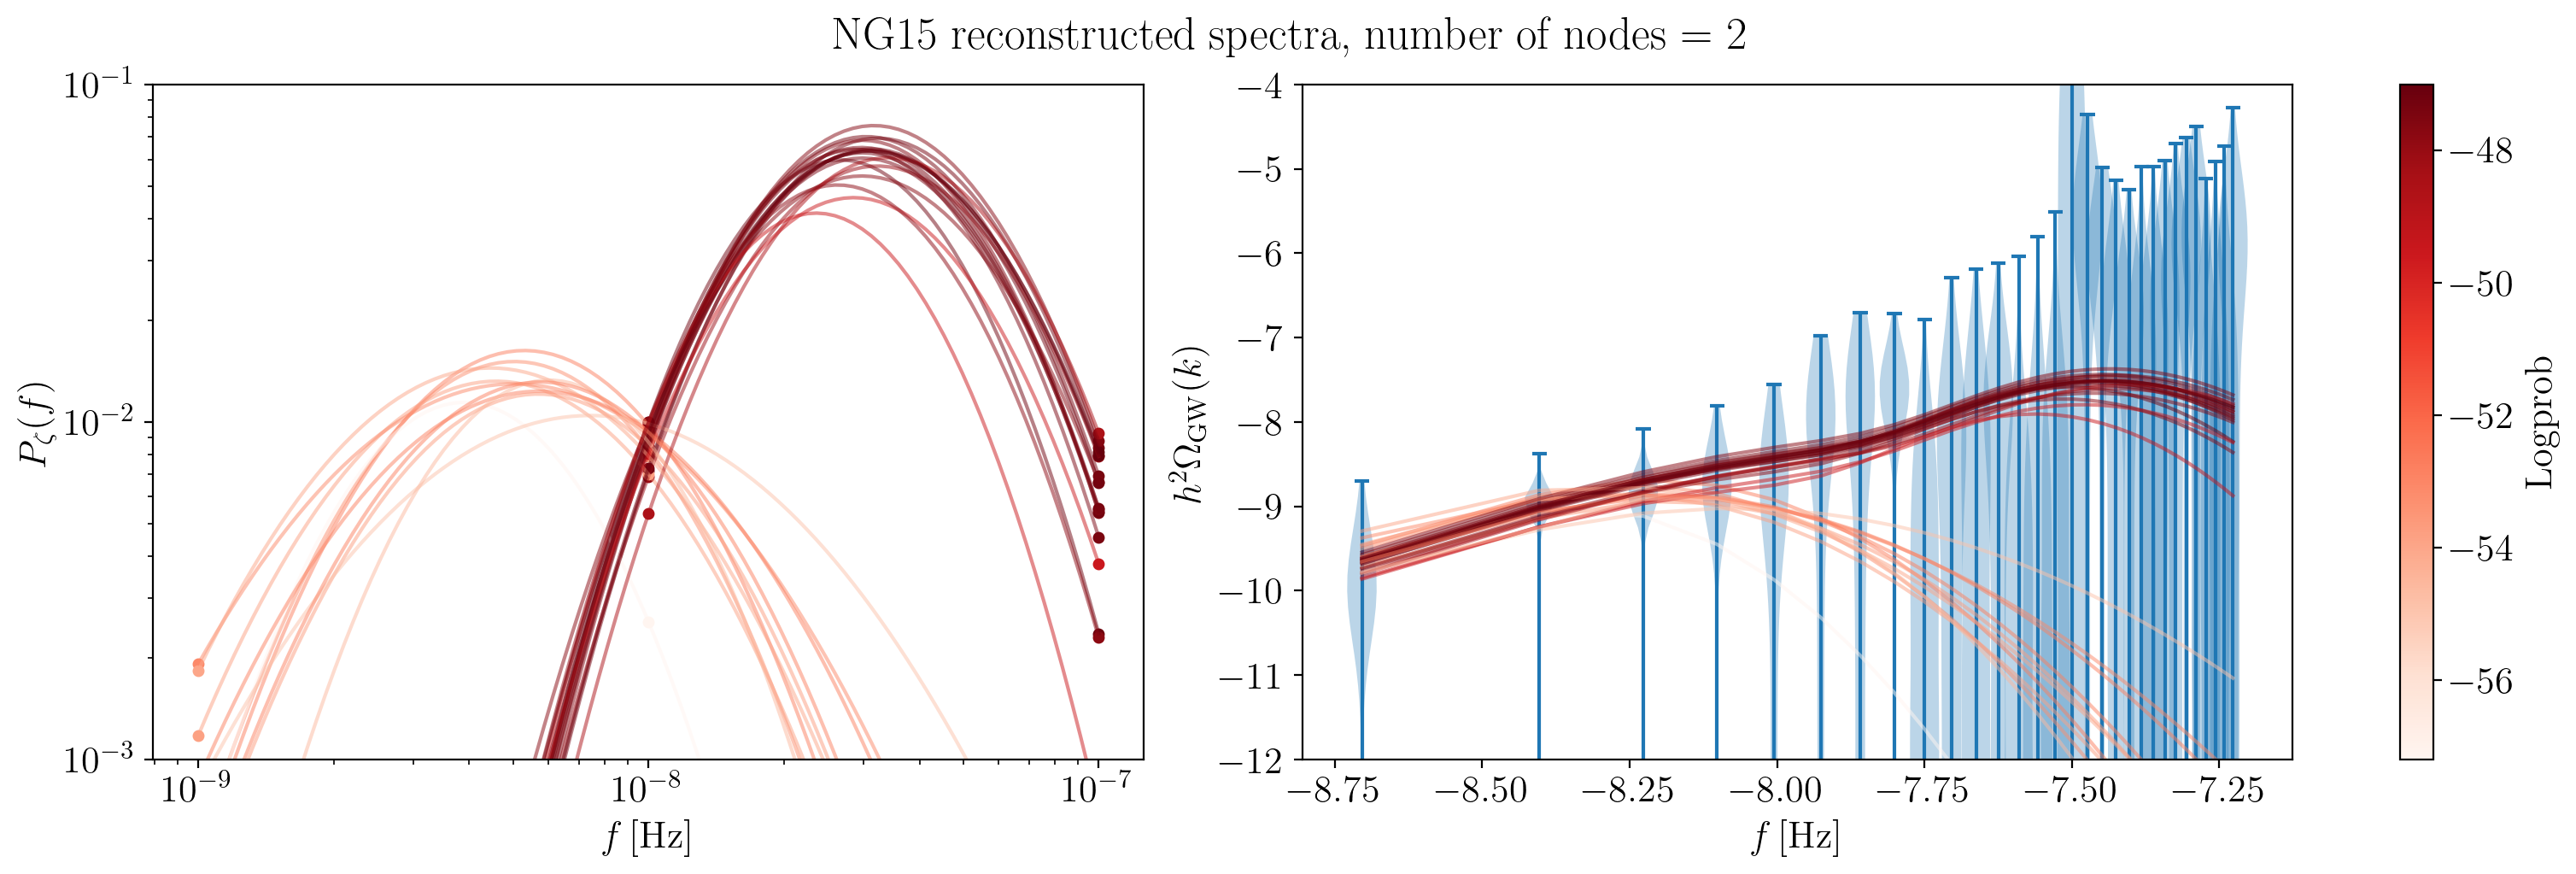

In [36]:
print(chain_data.shape)

frequencies = freqs

ys = chain_data[100:,:num_nodes]
logl = chain_data[100:,num_nodes+1]

thinning = 32
cmap = matplotlib.colormaps['Reds']
ys = ys[::thinning]
xs = nodes
lp = logl[::thinning] 
lp_min, lp_max = np.min(lp), np.max(lp)
cols = (lp-lp_min)/(lp_max - lp_min) # normalise the logprob to a colour
norm = colors.Normalize(lp_min,lp_max)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),layout='constrained')

ax1.set_xscale('log')
ax1.set_yscale('log')

# print(OmegaGW_data[0])
ax2.violinplot(list(OmegaGW_data),positions=np.log10(freqs),widths=0.05)
for pc in v1['bodies']:
    pc.set_facecolor(('C0',0.25))
    pc.set_edgecolor('C0')
    pc.set_linestyle('solid')
    pc.set_alpha(0.25)
    pc.set_linewidth(1.5)

p_arr = np.logspace(nodes[0],nodes[-1],100)

for i,y in enumerate(ys):
    gwb_amps = spectrum(freqs, *y)
    pz_amps = spline(nodes, y, p_arr)
    ax1.loglog(p_arr,pz_amps,color=cmap(cols[i]),alpha=0.5)
    ax1.scatter(10**(xs),10**(ys[i]),s=16,color=cmap(cols[i]))
    ax2.plot(np.log10(frequencies),np.log10(gwb_amps),color=cmap(cols[i]),alpha=0.5)


# ax2.legend()
ax1.set_ylabel(r'$P_{\zeta}(f)$')
ax1.set_xlabel(r'$f \,\mathrm{[Hz]}$')
# ax2.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')

ax2.set_ylabel(r'$h^2 \Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$f \,\mathrm{[Hz]}$')
fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=[ax1,ax2],label='Logprob')
ax1.set_ylim(1e-3,1e-1)
ax2.set_ylim(-12,-4)
ax.set_xlim(-8.8, -7.68)# plt.show()
fig.suptitle('NG15 reconstructed spectra, number of nodes = 2')
plt.savefig('NG15_reconstructed_spectra_3_nodes.pdf',bbox_inches='tight')